# Preamble & Initialization


In [1]:
series = "bertL005"
runLogPath="../save-epochs/squad_v2/deepset/bert-large-uncased-whole-word-masking-squad2/005"
 

This notebook captures and compares GR and GRIM information from each evaluation through a training experiment. It is an extension of [the general Analysis notebook](https://github.com/kamfonas/squadBERT/blob/main/notebooks/Analysis_using_hf_logs_v5_mk.ipynb).

It was built after an extension was added to the utils_qa script of Huggingface to retain all copies of gererated "nbest" information. 


In [2]:
#https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5
import pickle5 as pickle
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib
import wget
#from utils_anal import *
#rename things that arent logs later
import os
from pathlib import Path
import json
import gzip
from collections import Counter
import datetime
import datasets
from datasets import ClassLabel, Sequence, load_dataset, load_metric
import random
import pandas as pd
from IPython.display import display, HTML
import datetime
import string
import re
from statistics import  median_grouped
from utils_anal import *

# Utilities, Functions and Classes


## Exact Match and F1 Computation

In [3]:
def compute_em(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))
def normalize_answer(s):
    """Convert to lowercase and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()
def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    if not ground_truths:
        return metric_fn(prediction, '')
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)



In [4]:

def show_random_elements(dataset, num_examples=3):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))



## The ResultSet Class



To facilitate management and data collection we build a dictionary of available data sources derived from runs logged under a user-provided root directory (saveRoot.)

The SaveRoot descendent directories are searched for all instances of a fiile named *eval_nbest_predictions.json*. Every directory containing this file is a potential source for N-best predictions. We load the ones that satisfy these additional conditions:

1.  if a *config.json* file exists in the same directory
2.  If a file named *all_results.json* exists in the same directory

These files are written by the training/evaluation process after successful completion of a run. 

The function **get_resultsets_from_root(saveRoot)** performs the above steps and returns a directory with the following information:

<dl>
<dt><b>mtime</b></dt>
    <dd>The last modification time of the eval_nbest_predictions.json file</dd>
<dt><b>config</b></dt>
    <dd>Model configuration of used to produce the top-N results</dd>
<dt><b>all_results</b></dt>
    <dd>The results of the last run that produced the top-N results</dd>
<dt><b>topN</b></dt>
    <dd>A dictionary keyed on the ID of each question pointing to an ordered N-long list in descending order of probability with the predicted details. These details are organized as dictionaries containing:
    </ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b></li>
    </ul>
    </dd>
<dt><b>null odds</b></dt>
    <dd>The odds determining the likelihood that this is a no-answer question for each example</dd>
</dl>

We augment our **prediction** dictionary to include the **id** as a field, the **rank** of each predicted answer (with values from 0 to N), and the gold answers (**goldenAnswers**), which is a list containing the distinct text of the answers found in the SQuAD_V2 dataset. Finally, we also include an indicator showing whether the prediction is the **correct** answer.

The **contextLen** field denotes the original number of characters in the context field. This can be used for normalization when comparing probabilities of different size contexts. A more appropriate length would be the number of tokens or number of words in the context.  

Notice that to indicate no answer, the prediction text is an empty string while the goden answer is an empty list. 

The class, when initialized with a root directory, searches all its subdirectories to find top-N prediction output files. It also accepts an original examples dataset which was used as input to our training/evaluation script. From these two pieces of information, the class materializes a number of dictionaries and carries methods for data extraction and generating all necessary values for visualizations. 

Method topNPredsDF takes an optional maxBins parameter that sets a limit to the rank values. The function returns a pandas dataframe that contains the following columns:
    <ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b> derived from the combination of start and end probabilities</li>
    <li><b>experiment</b> derived from the output directory path</li>
    <li><b>example id</b></li>
    <li><b>rank</b> in descending order of probability for as many available ranks are available in the logs.
    <li><b>bins</b> this is driven by the topK parameter and is assigned the rank value up to the maxBins parameter. This is a convenient way to throttle very long top-N lists to a desired max size for plotting purposes. All the rows that exceed the rank are still available, but the rank number is the same maximum value (defaults to 20)</li>
    <li><b>correct</b> is True if it matches one of the golden answers using the exact match logic (EM) regardless of rank</li>
    <li><b>contextLen</b> in characters</li>
    </ul>



In [5]:
class ResultSet(object):
    def __init__(self,saveRoot,dataset, all_train_evals=False):
        """
            Build directory of saved output directories descendent of saveRoot
            that contain N-best predictions files

            arguments: 
                saveRoot (str): a relative or absolyte directory whose descendent
                                directories will be searched for N-best files
                dataset (datasets.arrow_dataset.Dataset): A dataset (e.g. validation) which
                            includes question, answer, id, answers for each of the original examples
                all_train_evals (Boolean): N-best files are compressed. They are found in directory
                            nbest and are named: eval_nbest_predictions.999.gz 
                            999 indicates the sequence of the evaluation runs. 
            returns:
                A dictionary keyed on directories that contain eval_nbest_predictions.json files
                with values:
                    mtime (iso datetime): the last modification time of the prediction file
                    config (dict): a dictionary of configuration data used for the run
                    all_results (dict): the evaluation and training results of the run
        """  
        super().__init__() 
        self.all_train_evals = all_train_evals
        self.dataset = dataset
        self.ix_id = dict([(x['id'],i) for i,x in enumerate(dataset)])
        self.saveRoot = Path(saveRoot)
        if all_train_evals:
            nbest_list = list(self.saveRoot.glob('**/eval_nbest_predictions.*.gz'))
        else:
            nbest_list = list(self.saveRoot.glob('**/eval_nbest_predictions.json'))
        self.nbest_list = sorted(nbest_list)
        self.experiments = []
        self.mtimes = []
        self.null_odds = []
        self._topNPreds = []
        self.configs = []
        self.results = []

        for p in self.nbest_list:
            config={}
            all_results = {}
            null_odds =  {}
            pred = {}

            pp = p.parent

            c = list(pp.glob('config.json'))
            if c and not all_train_evals: 
                with open(c[0]) as d:
                    config = json.load(d)

            r = list(pp.glob('all_results.json'))
            if r and not all_train_evals: 
                with open(r[0]) as d:
                    all_results = json.load(d)

            o = list(pp.glob("eval_null_odds.json"))
            if o and not all_train_evals: 
                with open(o[0]) as d:
                    null_odds = json.load(d)

            if (r and o) or all_train_evals:
                if all_train_evals:
                    with gzip.open(p, 'rt', encoding='UTF-8') as zipfile:
                        pred = json.load(zipfile)
                    nm = 'eval'+p.suffixes[0]
                else:
                    with open(p) as d:
                        pred = json.load(d)
                    nm = str(Path(p).parents[0]).replace(saveRoot,'')
                mtime = datetime.datetime.fromtimestamp(p.stat().st_mtime)
                self.experiments.append(nm)
                self.mtimes.append(mtime.isoformat())
                self.configs.append(config)
                self.results.append(all_results)
                self.null_odds.append(null_odds)
                self._topNPreds.append(pred)

 
        for nm, E in zip(self.summaryDF()['experiment'],self._topNPreds):
            for k,v in E.items():
                cxtLen = len(self.dataset[self.ix_id[k]]['context'])
                gL = self.dataset[self.ix_id[k]]['answers']['text']
                ga= list(set(gL))
                for i,x in enumerate(sorted(v,reverse=True,key=lambda s: s['probability'])):
                    x['experiment'] = nm
                    x["id"] = k
                    x["rank"] = i
                    x["goldAns"] = ga
                    if ga == [] :
                        corr = compute_em('',x['text'])==1
                    else:
                        corr = any([compute_em(a,x['text'])==1 for a in ga])
                    x["correct"] = corr
                    x["contextLen"] = cxtLen
        self.labels = self.experiments
    
    def set_labels(self,labels):
        assert len(labels) == len(self.experiments), "Labels list must be the same size as the experiments list"
        self.labels=labels
        
    def summaryDF(self):
        c = [len(x) for x in self._topNPreds]
        k = [ max([len(L) - 1 for L in E.values()]) for E in self._topNPreds ]
        res = pd.DataFrame([self.experiments,self.mtimes,c,k]).transpose()
        res.columns = ['experiment','mtime','example_count', 'topK']
    
        return res

    def topNPreds(self,topK=20, experimentIdx = None):
        if experimentIdx:
            Es = [self._topNPreds[experimentIdx]]
        else:
            Es = self._topNPreds
        results = []
        for E in Es:
            for L in E.values():
                for x in L:
                    x['bin'] = min(x['rank'],topK)
            results.append(E)
        return results

    def topNPredsDF(self,topK=20, experimentIdx = None):
        if experimentIdx:
            Es = [self._topNPreds[experimentIdx]]
        else:
            Es = self._topNPreds
        results = []
        for E in Es:
            for L in E.values():
                for x in L:
                    x['bin'] = min(x['rank'],topK)
                    results.append(x)
        return pd.DataFrame(results)

    def show_random_qa_predictions(self, experimentIdx, num_examples=3, verbose = True):
        dataDict = self._topNPreds[experimentIdx]
        assert num_examples <= len(dataDict), "Can't pick more elements than there are in the dataset."
        picks = []
        for _ in range(num_examples):
            pick = (random.randint(0, len(dataDict)-1))
            while pick in picks:
                pick = random.randint(0, len(dataDict)-1)
            picks.append(pick)

        keys = [list(dataDict.keys())[i] for i in picks]
        dv = [dataDict[pick] for pick in keys]
        df = pd.DataFrame([r for v in dv for r in v ])
        for column, typ in df.items():
            if isinstance(typ, ClassLabel):
                df[column] = df[column].transform(lambda i: typ.names[i])
            elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
                df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
        df = df.loc[:,['id','rank','text','goldAns','probability','correct']]
        if verbose:
            display(HTML(df.to_html()))
        return(df)

    def calc_golden_ranks(self, maxBins=9999,experimentIdx=None):
        '''
        This method calculates and returns four numpy arrays, each containing a metric for the highest ranking 
        prediction that exactly matches one of the golden answers. The four metrics are: 
        1. The rank of the prediction up to the parameter maxBins. Lower ranks (higher rank numbers) are given the
           same value equal to maxBins. 
        2. The probability of the highest ranking match, or zero if there is no match in the top-K predictions.
        3. The top probability (at rank=0) for the example.
        4. The actual value of maxBins (highest value in the first array)
        '''
        grls = []
        nas = []
        grls_na = []
        grlProbs = []
        topProbs = []
        mediansNonZeroRanks = []
        for E in self.topNPreds(topK=maxBins,experimentIdx=experimentIdx):
            grl = []
            na = []
            #grlProb = []
            #topProb = []
            for id,v in E.items():
                gr = maxBins
                grp = 0
                pr  = v[0]['probability']
                for x in sorted(v,reverse=True,key=lambda s: s['probability']):
                    if x['correct'] == True:
                        gr = x['bin']
                        grp = x['probability']
                        break
                grl.append(gr)
                na.append(v[0]['goldAns']==[])
                #grlProb.append(grp)
                #topProb.append(pr)
            grls.append(grl)
            nas.append(na)
            #grlProbs.append(grlProb)
            #topProbs.append(topProb)
            mediansNonZeroRanks.append(median_grouped([r  for r in grl if r>0]))
        grls_np = np.array(grls)
        nas_np = np.array(nas)
        #grlProbs_np = np.array(grlProbs)
        #topProbs_np = np.array(topProbs)
        mediansNonZeroRanks_np = np.array(mediansNonZeroRanks)
        check = np.array(self.summaryDF()['example_count'])[0]
        #print('grls_np shape:',grls_np.shape)
        assert grls_np.shape[1] == check, 'result length should be equal to keys in pred'
        #assert grlProbs_np.shape[1] == check, 'result length should be equal to keys in pred'
        #assert topProbs_np.shape[1] == check, 'result length should be equal to keys in pred'
        maxBinsActual = np.max(grls_np)
        #print('maxBins:',maxBins)
        # No grlProbs_np, topProbs_np
        return grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls

    def eval_metrics(self):
        res = [{'EM_ans':E['eval_HasAns_exact'],
                'F1_ans':E['eval_HasAns_f1'],
                'F1-EM_ans_delta':E['eval_HasAns_f1']-E['eval_HasAns_exact'],
                'noans':E['eval_NoAns_exact'],
                'EM':E['eval_exact'],
                'F1':E['eval_f1'],
                'F1-EM_delta':E['eval_f1']-E['eval_exact']} for E in self.results]
        return pd.DataFrame(res)


## Plot Golden EM by Rank

In [6]:

def plot_golden_EM_by_rank(grls_np, medians=[], cumulative = False,
                        skipRank0=False,labels=None,savePath=None ):
    lowx = 1 if skipRank0 else 0
    title = '%sEM by Gold Pred-Rank' % ('Cumulative ' if cumulative else '')
    title = '%s%s' % (title,'\n(Ranks > 0 only)' if skipRank0 else '')
    colors = cm.Paired(np.linspace(0, 1, len(grls_np)))
    m = grls_np.shape[1]
    maxBins = np.max(grls_np)
    bins = [x for x in range(maxBins+2)]
    xticks = [(bins[idx] + value)/2 for idx, value in enumerate(bins[:-1])]     
    xticks_labels = [ "{:.0f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
    xticks_labels[-1] = xticks_labels[-1]+'+'
    plt.xticks(xticks, labels = xticks_labels)
    plt.tick_params(axis='x', which='max',length=0)
    A = plt.hist(grls_np.T,bins=maxBins+1,
            weights=np.ones(grls_np.T.shape)*100/m, 
            cumulative=cumulative,align='left',histtype='bar',
            range=(lowx,(maxBins+1)),
             color=colors)
    if labels:
        if savePath:
            if cumulative:
                plt.legend(labels=labels,loc='lower right', bbox_to_anchor=(1, 0))
            else:
                plt.legend(labels=labels,loc='upper right', bbox_to_anchor=(1, 1))
        else:
            plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1, 1))
    if len(medians) > 0:
        plt.vlines(x=medians,ymin=0,ymax=100, linestyles=':',color=colors,alpha=0.5)
        title = '%s%s' % (title,'\nDotted Lines show Interpolated Median of Ranks > 0')
    plt.title(title)
    # x ticks
    if savePath:
        plt.savefig(savePath,dpi=300,alpha=0.6)
    plt.show()

    return A[0], medians


## Agglomerative Clustering by GR (Birch)

In [7]:

# Birch clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def cluster_examples_by_GR(X = None, X_means= None, X_std = None, maxBins = 10, K_clusters = 4, slice_descr="All Examples", 
        save_path = None ):
    '''
    Clusters examples by their Golden Rank of each experiment they participate in. It also prints a graph with 
    
    Arguments:
        X = numpy array of shape (NumberOfExamples X NumberOfExperiments) with the GR values
        X_means = Vector of size (NumberOfExamples) holding the mean of the GRs across the experiments
        X_std   = Vector of size (NumberOfExamples) holding the respective standard deviations
        maxBins = The number of GRs from 0 to maxBins -1. An extra bin with value maxBins is used to capture GR >= maxBins
        K_clusters = The number of clusters
        slice_descr = a description of the population being analyzed used in the title of the graph (e.g. "All Examples" or "Unanswerable Examples")
        save = a valid path where to save the plot, if provided.
    Returns:
        A pandas data frame that contains K-cluester + 2 rows. The first row reports the number of examples successfully predicted (GR = 0) all experiments.
        The last row reports the examples that have no experiment produce a GR < maxBins. These are all the examples that have higher GRs for all experiments.
        The remaining rows (one per cluster) are organized in ascending order of their X-axis value, i.e. the first cluster is closer to rank 0. 
        The following columns are reported:

            Characterization:   The first and last row have values "All Correct" and "All Wrong" respectively. The clusters closest to these two ends 
                                contain values "Mostly Correct" and "Mostly Wrong", while the rest carry the value "Uncertain"  
            Counts:             The count of examples in the cluster. The first and last cluster have the "All Correct"  and "All Wrong" values subtracted from
                                the respective clusters they belong, since they are reported in the first and last row.
            formMeans, toMeans  The range of mean values of the cluster (x-axis)
            fromStd, toStd      The ranfe of standard deviations (y-axis)
    '''
    # Cluster examples by their GR in each experiment they participated
    model = Birch(threshold=0.001,n_clusters=K_clusters)
    model.fit(X)
    yhat = model.predict(X) # vector: cluster ID for each example

    clusters = unique(yhat) # unique clusters
    colors = cm.rainbow(np.linspace(0, 1, len(clusters)))

    X0=np.sum(np.sum(X,axis = 1)==0)
    X10=np.sum(np.mean(X,axis = 1)==maxBins)
    df0=pd.DataFrame({'Characterization': 'All Correct','Counts':X0,'fromMeans':0,'toMeans':0,'fromStd':0,'toStd':0},index=[0])
    df10=pd.DataFrame({'Characterization':'All Wrong','Counts':X10,'fromMeans':0,'toMeans':0,'fromStd':0,'toStd':0},index=[0])



    counts_pd = pd.DataFrame([sum(yhat==c) for c in clusters],clusters, columns = ['Counts'])
    toMeans = [max([X_means[i] for i in [x for x in where(yhat==c)][0]]) for c in clusters]
    fromMeans= [min([X_means[i] for i in [x for x in where(yhat==c)][0]]) for c in clusters]
    toStd = [max([X_std[i] for i in [x for x in where(yhat==c)][0]]) for c in clusters]
    fromStd= [min([X_std[i] for i in [x for x in where(yhat==c)][0]]) for c in clusters]
    counts_pd['Characterization'] = 'Uncertain'
    counts_pd['fromMeans'] = fromMeans
    counts_pd['toMeans'] = toMeans
    counts_pd['fromStd'] = fromStd
    counts_pd['toStd'] = toStd
    counts_pd=counts_pd.sort_values('fromMeans')
    counts_pd.loc[counts_pd['fromMeans']==0,'Counts']=counts_pd['Counts']-X0
    counts_pd.loc[counts_pd['toMeans']==maxBins,'Counts']=counts_pd['Counts']-X10
    counts_pd.loc[counts_pd['fromMeans']==0,'Characterization']='Mostly Correct'
    counts_pd.loc[counts_pd['toMeans']==maxBins,'Characterization']='Mostly Wrong'
    counts_pd = pd.concat([df0,counts_pd,df10])
    counts_pd.index=range(len(counts_pd))


    fig, ax = plt.subplots()
    #fig.set_ppi(150.0)
    ax.scatter(X_means,X_std,alpha = 0.3, marker = '.',s=3,color = colors[yhat])

    xys = [(x,y) for x,y in zip(fromMeans,fromStd)]
    ws = [x2-x1 for x1,x2 in zip(fromMeans,toMeans)]
    hs = [y2-y1 for y1,y2 in zip(fromStd,toStd)]
    for xy,w,h,col in zip(xys,ws,hs,colors[clusters]):
        ax.add_patch( Rectangle(xy,w,h,fc='none',
                            color =col,
                            linewidth = 1,
                            linestyle="dashed") )
    plt.xlabel("Example Golden Rank Mean across Experiments")
    plt.ylabel("Standard Deviation")
    plt.title("Examples Clustered by GR of each Experiment\nBirch Clustering - K=%i - %s"%(K_clusters,slice_descr))
    if save_path:
        plt.savefig(str(save_path),dpi=300.0)
    fig.show()

    return counts_pd

# SQuAD Dataset


## Load the SQuAD Dataset

We now download the squad_v2 dataset from the hub. We will use it to get the golden answers so that we can calculate performance metrics. The dataset class has a method for loading the dataset from the huggingface hub or from a disk location. The loaded object belongs to that class



In [8]:
dataset_name = "squad_v2"

raw_datasets = load_dataset(dataset_name)
print('The raw dataset dictionary contains two datasets of type %s:' % (type(raw_datasets["validation"])))
raw_datasets

#['num_rows']


Reusing dataset squad_v2 (/home/farsipal/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


The raw dataset dictionary contains two datasets of type <class 'datasets.arrow_dataset.Dataset'>:


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

The following function allows us to inspect the contents of the downloaded data. Every time the function is invoked it prduces a new set of random selections.

In [9]:
show_random_elements(raw_datasets["validation"])

,id,title,context,question,answers
0,5ad5071f5b96ef001a10aa3c,Warsaw,"The mermaid (syrenka) is Warsaw's symbol and can be found on statues throughout the city and on the city's coat of arms. This imagery has been in use since at least the mid-14th century. The oldest existing armed seal of Warsaw is from the year 1390, consisting of a round seal bordered with the Latin inscription Sigilium Civitatis Varsoviensis (Seal of the city of Warsaw). City records as far back as 1609 document the use of a crude form of a sea monster with a female upper body and holding a sword in its claws. In 1653 the poet Zygmunt Laukowski asks the question:",What does the sea monster with an inscription on its claws?,"{'text': [], 'answer_start': []}"
1,5a638b3668151a001a92235a,Victoria_(Australia),"As of August 2010, Victoria had 1,548 public schools, 489 Catholic schools and 214 independent schools. Just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. Over 61 per cent of private students attend Catholic schools. More than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. Retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. Victoria has about 63,519 full-time teachers.",By August 2010 how many trade schools did Victoria have?,"{'text': [], 'answer_start': []}"
2,5a38d2f9a4b263001a8c193d,1973_oil_crisis,"Compact trucks were introduced, such as the Toyota Hilux and the Datsun Truck, followed by the Mazda Truck (sold as the Ford Courier), and the Isuzu-built Chevrolet LUV. Mitsubishi rebranded its Forte as the Dodge D-50 a few years after the oil crisis. Mazda, Mitsubishi and Isuzu had joint partnerships with Ford, Chrysler, and GM, respectively. Later the American makers introduced their domestic replacements (Ford Ranger, Dodge Dakota and the Chevrolet S10/GMC S-15), ending their captive import policy.",What did Toyota rebrand its Forte as?,"{'text': [], 'answer_start': []}"


We are interested in the validation dataset. The following is repeated from the orginal notebook:

# Search and Load Results from Anchor Directory

In [10]:
RS = ResultSet(runLogPath,raw_datasets["validation"],all_train_evals=True)


## Summarize What Was Loaded

In [11]:
list(RS.summaryDF()['experiment'])


['eval.000',
 'eval.001',
 'eval.002',
 'eval.003',
 'eval.004',
 'eval.005',
 'eval.006',
 'eval.007',
 'eval.008',
 'eval.009',
 'eval.010',
 'eval.011',
 'eval.012',
 'eval.013',
 'eval.014',
 'eval.015',
 'eval.016',
 'eval.017',
 'eval.018',
 'eval.019',
 'eval.020',
 'eval.021',
 'eval.022',
 'eval.023',
 'eval.024',
 'eval.025',
 'eval.026',
 'eval.027',
 'eval.028',
 'eval.029',
 'eval.030',
 'eval.031',
 'eval.032',
 'eval.033',
 'eval.034',
 'eval.035',
 'eval.036',
 'eval.037',
 'eval.038',
 'eval.039',
 'eval.040',
 'eval.041',
 'eval.042',
 'eval.043',
 'eval.044',
 'eval.045',
 'eval.046',
 'eval.047',
 'eval.048',
 'eval.049',
 'eval.050',
 'eval.051',
 'eval.052',
 'eval.053',
 'eval.054',
 'eval.055',
 'eval.056',
 'eval.057',
 'eval.058',
 'eval.059',
 'eval.060',
 'eval.061',
 'eval.062',
 'eval.063',
 'eval.064',
 'eval.065',
 'eval.066',
 'eval.067',
 'eval.068',
 'eval.069',
 'eval.070',
 'eval.071',
 'eval.072',
 'eval.073',
 'eval.074',
 'eval.075',
 'eval.076',

In [12]:
RS.summaryDF()

,experiment,mtime,example_count,topK
0,eval.000,2021-10-08T19:58:51.520891,11873,10
1,eval.001,2021-10-08T20:23:37.235357,11873,10
2,eval.002,2021-10-08T20:48:22.905759,11873,10
3,eval.003,2021-10-08T21:13:09.204530,11873,10
4,eval.004,2021-10-08T21:37:55.670146,11873,10
...,...,...,...,...
75,eval.075,2021-10-10T02:49:09.340364,11873,10
76,eval.076,2021-10-10T03:13:38.071165,11873,10
77,eval.077,2021-10-10T03:38:06.221436,11873,10
78,eval.078,2021-10-10T04:02:34.565657,11873,10


## Looking-up Information for a Specific Example ID

In [13]:
RS.dataset[RS.ix_id['571c96095efbb31900334dc0']] 

{'id': '571c96095efbb31900334dc0',
 'title': 'Oxygen',
 'context': 'Oxygen is more soluble in water than nitrogen is. Water in equilibrium with air contains approximately 1 molecule of dissolved O\n2 for every 2 molecules of N\n2, compared to an atmospheric ratio of approximately 1:4. The solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·L−1) dissolves at 0 °C than at 20 °C (7.6 mg·L−1). At 25 °C and 1 standard atmosphere (101.3 kPa) of air, freshwater contains about 6.04 milliliters (mL) of oxygen per liter, whereas seawater contains about 4.95 mL per liter. At 5 °C the solubility increases to 9.0 mL (50% more than at 25 °C) per liter for water and 7.2 mL (45% more) per liter for sea water.',
 'question': 'How much more oxygen dissolves at 0 degrees C than at 20 degrees C?',
 'answers': {'text': ['twice',
   '50% more',
   'about twice as much',
   'twice as much',
   'twice'],
  'answer_start': [286, 579, 280, 286, 286]}}

In [14]:
RS.topNPreds()[0]['5728fc9e1d04691400778f15'][1]

{'start_logit': -1.253394365310669,
 'end_logit': -0.07655654847621918,
 'text': '',
 'probability': 0.27320021390914917,
 'experiment': 'eval.000',
 'id': '5728fc9e1d04691400778f15',
 'rank': 1,
 'goldAns': ["the leaflets will have to be given to the leafleter's own jury as evidence",
  "if they arrest fully informed jury leafleters, the leaflets will have to be given to the leafleter's own jury as evidence"],
 'correct': False,
 'contextLen': 1453,
 'bin': 1}

In [15]:
RS.dataset[RS.ix_id['5728fc9e1d04691400778f15']] 

{'id': '5728fc9e1d04691400778f15',
 'title': 'Civil_disobedience',
 'context': 'Courts have distinguished between two types of civil disobedience: "Indirect civil disobedience involves violating a law which is not, itself, the object of protest, whereas direct civil disobedience involves protesting the existence of a particular law by breaking that law." During the Vietnam War, courts typically refused to excuse the perpetrators of illegal protests from punishment on the basis of their challenging the legality of the Vietnam War; the courts ruled it was a political question. The necessity defense has sometimes been used as a shadow defense by civil disobedients to deny guilt without denouncing their politically motivated acts, and to present their political beliefs in the courtroom. However, court cases such as U.S. v. Schoon have greatly curtailed the availability of the political necessity defense. Likewise, when Carter Wentworth was charged for his role in the Clamshell Alliance\'s 

## Explore random example top-K predictions


Let's explore the RS class and look at a few random examples. 

1.  We first select **num_examples** (default to 3) numbers in the range of all the keys of the data dictionary
2.  Look up the keys that appear at these three sequencial positions in the sequence of all keys
3.  Get the values pointed to by those keys
4.  Build a data frame by traversing the list of each of the chosen values and extracting the field names and fields.
5.  Finally display the rank, predicted answer text,  golden answer list,  probability used to rank this choice, and whether this is a correct prediction. 

Every time the command is issued new random samples are displayed. 

In [16]:
DF = RS.show_random_qa_predictions(3,num_examples = 2, verbose = False)
DF


,id,rank,text,goldAns,probability,correct
0,572fc49d04bcaa1900d76ccb,0,5 pm,[5 pm],9.941897e-01,True
1,572fc49d04bcaa1900d76ccb,1,at 5 pm,[5 pm],4.204478e-03,False
2,572fc49d04bcaa1900d76ccb,2,5,[5 pm],1.250164e-03,False
3,572fc49d04bcaa1900d76ccb,3,"5 pm,",[5 pm],3.009276e-04,True
4,572fc49d04bcaa1900d76ccb,4,normally at 5 pm,[5 pm],2.583856e-05,False
5,572fc49d04bcaa1900d76ccb,5,pm,[5 pm],1.772041e-05,False
6,572fc49d04bcaa1900d76ccb,6,at 5,[5 pm],5.287002e-06,False
7,572fc49d04bcaa1900d76ccb,7,"sitting day, normally at 5 pm",[5 pm],2.828104e-06,False
8,572fc49d04bcaa1900d76ccb,8,"5 pm, MSPs decide on all the motions and amend...",[5 pm],1.628017e-06,False
9,572fc49d04bcaa1900d76ccb,9,"at 5 pm,",[5 pm],1.272637e-06,False


# Metrics

In [17]:
preds = RS.topNPreds(topK=1)


In [18]:
all_scores = []
e_idx = 0
id_idx = 0
for exp_idx, experiment in enumerate(preds):
    scores = {}
    for id,L in experiment.items():
        id_idx += 1
        for v in L:
            if v['rank'] == 0:
                noAns = (v['goldAns'] == [])
                F1 = metric_max_over_ground_truths(compute_f1,prediction=v['text'],ground_truths=v['goldAns'])
                EM = metric_max_over_ground_truths(compute_em,prediction=v['text'],ground_truths=v['goldAns'])
                scores[id]=(F1,EM,noAns)
                break
            scores[id] = (None,None,v['rank'])
    all_scores.append(scores)
                


In [19]:
print('number of evaluations scored:', len(all_scores))
print('example counts processed:',[len(v) for v in all_scores])
print('571112ada58dae1900cd6bcd',all_scores[len(all_scores)-1]['571112ada58dae1900cd6bcd'])
print('5acfef5477cf76001a686583',all_scores[len(all_scores)-1]['5acfef5477cf76001a686583'])
F1s = [np.mean([f1 for k,(f1,em,noAns) in s.items() ])*100 for s in all_scores ]
EMs = [np.mean([em for k,(f1,em,noAns) in s.items() ])*100 for s in all_scores ]
F1s_ans = [np.mean([f1 for k,(f1,em,noAns) in s.items() if noAns == False])*100 for s in all_scores ]
EMs_ans = [np.mean([em for k,(f1,em,noAns) in s.items() if noAns == False])*100 for s in all_scores ]
F1s_na = [np.mean([f1 for k,(f1,em,noAns) in s.items() if noAns == True])*100 for s in all_scores ]
EMs_na = [np.mean([em for k,(f1,em,noAns) in s.items() if noAns == True])*100 for s in all_scores ]


number of evaluations scored: 80
example counts processed: [11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873, 11873]
571112ada58dae1900cd6bcd (1.0, 1, False)
5acfef5477cf76001a686583 (1, 1, True)


In [21]:
metrics1 = pd.DataFrame([EMs,F1s,EMs_ans,F1s_ans,EMs_na,F1s_na]).T
metrics1.columns=['EMs','F1s','EMs_ans','F1s_ans','EMs_na','F1s_na']
metrics1

,EMs,F1s,EMs_ans,F1s_ans,EMs_na,F1s_na
0,76.290744,80.189013,75.067476,82.875193,77.510513,77.510513
1,77.436200,80.690468,73.043185,79.561053,81.816653,81.816653
2,76.686600,80.139982,76.518219,83.434887,76.854500,76.854500
3,76.316011,79.631021,74.662618,81.302144,77.964676,77.964676
4,75.802240,79.231414,76.197706,83.065887,75.407906,75.407906
...,...,...,...,...,...,...
75,78.556388,82.081698,77.395412,84.456140,79.714045,79.714045
76,78.497431,82.008775,77.277328,84.310084,79.714045,79.714045
77,78.463741,82.023913,77.412281,84.542833,79.512195,79.512195
78,78.404784,81.925997,77.665317,84.717842,79.142136,79.142136


# GR Frequency Analysis



## Top-10 GRs - Evals during Training (Bert-base)

We show every 5th evaluation occurring every 2000 optimizer iterations during a 12-epoch training run. 

We first extract the top-K ranking predictions for each experiment. 

In [22]:
grls_np, nas_np, maxBins, medians, grls = RS.calc_golden_ranks(maxBins = 10,experimentIdx=None)


To avoid clutter we only plot every 5th evaluation of the training cycle.

In [23]:
N = len(medians)
L = [i for i in range(0,N,10)]
L

[0, 10, 20, 30, 40, 50, 60, 70]

In [24]:
#L= [0,2,5,9, 13,17,20,28,37,49]
#L= [5, 49,37, 39]


We can now plot the topN golden predictions by rank. We superimpose the medians of ranks > 0.

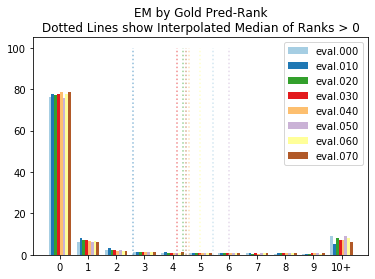

array([5.44086022, 2.59444444, 4.35514019, 4.17307692, 4.57216495,
       6.00769231, 4.96111111, 4.48214286])

In [25]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rankEval_%s.png'%series )
Ms
#Hs

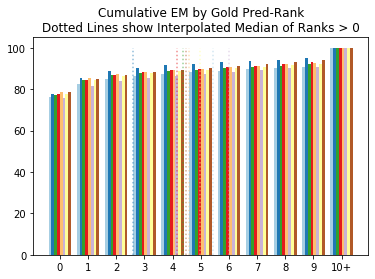

In [26]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rankEval%s.png'%series )


# Clustering of Examples by Model Performance

In [27]:
grs = grls_np
grs_na = grls_np[:,list(nas_np[0,:])]
grs_ans = grls_np[:,list(nas_np[0,:]==0)]
grs_means = [np.mean(x) for x in grs.T]
grs_na_means = [np.mean(x) for x in grs_na.T]
grs_ans_means = [np.mean(x) for x in grs_ans.T]
grs_std = [np.std(x) for x in grs.T]
grs_na_std = [np.std(x) for x in grs_na.T]
grs_ans_std = [np.std(x) for x in grs_ans.T]
grs_pr = grls_np[:,list(np.min(grls_np,axis=0) == 0)]

#grs_pr_na = grls_np[:,list(np.min(grls_np,axis=0) == 0 and nas_np[0,:])]

grs_sec = grls_np[:,list(np.min(grls_np,axis=0) > 0)]
grs_pr_means = [np.mean(x) for x in grs_pr.T]
grs_pr_std = [np.std(x) for x in grs_pr.T]
grs_sec_means = [np.mean(x) for x in grs_sec.T]
grs_sec_std = [np.std(x) for x in grs_sec.T]


## GR Mean & std Scaterplots



### All experiments by Example



We plot the 15 experiment golden rank mean vs. the standard deviation for each example. The first plot below distinguishes the examples into two categories: The gray points denote those examples predicted  correctly by at least one experiment. The blue points denote the rest of the examples that only appeared in secondary predictions.

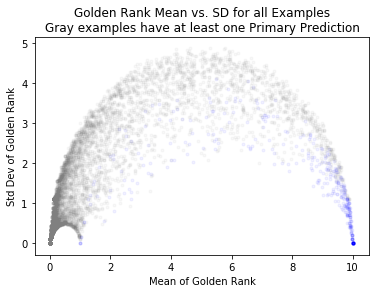

In [28]:
plt.scatter(grs_pr_means,grs_pr_std,alpha = 0.05, marker = '.',color = 'grey')
plt.scatter(grs_sec_means,grs_sec_std,alpha = 0.05, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Golden Rank Mean vs. SD for all Examples\nGray examples have at least one Primary Prediction")
plt.savefig('../assets/GR_mean_vs_std_Predicted_by_at_least_one_model_%s.png'%series,dpi=300)

The following statistics pertain to examples that have been predicted correctly at least once:

In [28]:
m=grls_np.shape[1]
pr_na = np.sum([ a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr_ans = np.sum([ not a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr = np.sum(np.min(grls_np,axis=0) == 0)

print ('There are %i examples that have been predicted correctly by at leat one experiment' % pr)
print('They are about evenly split between answerable (%i) and unanswearable (%i) examples'% (pr_ans,pr_na))
print ('The remaining %i examples (%.2f%%) are the only ones that appear exclusively in secondary predictions and none of the primary' %\
    (m-pr, (m-pr)/m*100))


There are 11507 examples that have been predicted correctly by at leat one experiment
They are about evenly split between answerable (5746) and unanswearable (5761) examples
The remaining 366 examples (3.08%) are the only ones that appear exclusively in secondary predictions and none of the primary


The second graph shows the same mean-standard deviation plot for each example, in green for answerable examples and  red for those that have no answer.The answerable examples are more consistently predicted by the 15 models and remain closer to the higher ranking predictions (towards 0) while the no-answer examples are predicted less successfully and with wider variability.

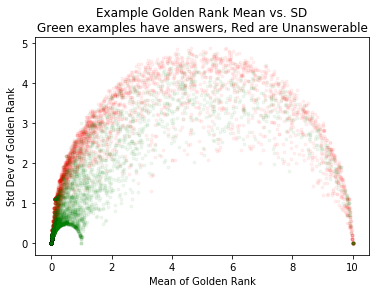

In [29]:
plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
plt.scatter(grs_ans_means,grs_ans_std,alpha = 0.05, marker = '.',color = 'green')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Example Golden Rank Mean vs. SD\nGreen examples have answers, Red are Unanswerable")
plt.savefig('../assets/GR_mean_vs_std_ans_vs_noAns_%s.png'%series,dpi=300)

The following experiment counts correspond to the three points with zero standard deviation. These denote examples that have been consistently ranked for all 15 experiments.

In [30]:
m = len(grs_means)
print('Examples ranked 0 for all experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_means]),np.sum([x==0 for x in grs_means])/m*100))
print('Examples ranked 10 or higher for all experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_means]),np.sum([x==10 for x in grs_means])/m*100))
v01 = np.sum([x==0 for x in grs_std])-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
print('Examples ranked 1 for all experiments: %i or %.2f%%' % (v01,v01/m*100))
print('Examples ranked 0 for all experiments with no answer: %i or %.2f%%'%(np.sum([x==0 for x in grs_na_means]),np.sum([x==0 for x in grs_na_means])/m*100))
print('Examples ranked 10 or higher for all experiments with no answer: %i or %.2f%%'%(np.sum([x==10 for x in grs_na_means]),np.sum([x==10 for x in grs_na_means])/m*100))
v11 = np.sum([x==0 for x in grs_na_std])-np.sum([x==10 for x in grs_na_means])-np.sum([x==0 for x in grs_na_means])
print('Examples ranked 1 for all experiments with no answer: %i or %.2f%%'%(v11,v11/m*100))
print('Examples ranked 0 for all answerable experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_ans_means]),np.sum([x==0 for x in grs_ans_means])/m*100))
print('Examples ranked 10 or higher for all answerable experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_ans_means]),np.sum([x==10 for x in grs_ans_means])/m*100))
v21=np.sum([x==0 for x in grs_ans_std])-np.sum([x==10 for x in grs_ans_means])-np.sum([x==0 for x in grs_ans_means])
print('Examples ranked 1 for all answerable experiments: %i or %.2f%%'%(v21,v21/m*100))



#grs.shape

Examples ranked 0 for all experiments: 4656 or 39.22%
Examples ranked 10 or higher for all experiments: 35 or 0.29%
Examples ranked 1 for all experiments: 4 or 0.03%
Examples ranked 0 for all experiments with no answer: 2659 or 22.40%
Examples ranked 10 or higher for all experiments with no answer: 22 or 0.19%
Examples ranked 1 for all experiments with no answer: 0 or 0.00%
Examples ranked 0 for all answerable experiments: 1997 or 16.82%
Examples ranked 10 or higher for all answerable experiments: 13 or 0.11%
Examples ranked 1 for all answerable experiments: 4 or 0.03%


### Other Clustering attempts

/tmp/ipykernel_1167007/808314742.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4656     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    4349     0.0000   2.1375 0.000000 3.290517
       Uncertain    1248     0.0500   6.2875 0.398238 4.581877
       Uncertain     291     1.3375   7.4000 2.035582 4.886829
       Uncertain     645     2.1000   8.3125 2.095792 4.896363
    Mostly Wrong     649     5.4750  10.0000 0.000000 4.471507
       All Wrong      35     0.0000   0.0000 0.000000 0.000000


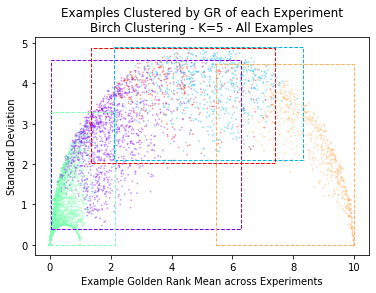

In [31]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 5

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster5_all_%s.png"%series) )
counts_pd.to_latex(index=False)
print(counts_pd.to_string(index=False))


/tmp/ipykernel_1167007/808314742.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4656      0.000   0.0000 0.000000 0.000000
  Mostly Correct    4349      0.000   2.1375 0.000000 3.290517
       Uncertain    1539      0.050   7.4000 0.398238 4.886829
       Uncertain     645      2.100   8.3125 2.095792 4.896363
    Mostly Wrong     649      5.475  10.0000 0.000000 4.471507
       All Wrong      35      0.000   0.0000 0.000000 0.000000


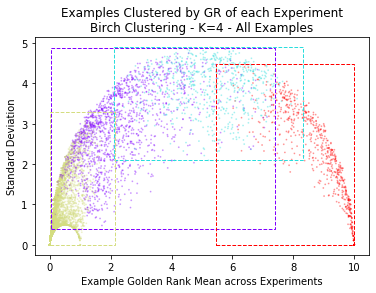

In [32]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster4_all_%s.png"%series) )
counts_pd.to_latex(index=False)
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2659     0.0000   0.0000  0.00000 0.000000
  Mostly Correct    2281     0.0000   5.9375  0.00000 4.886829
       Uncertain     478     1.8875   7.6375  2.09165 4.896363
    Mostly Wrong     505     5.6250  10.0000  0.00000 4.624324
       All Wrong      22     0.0000   0.0000  0.00000 0.000000


/tmp/ipykernel_19916/808314742.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


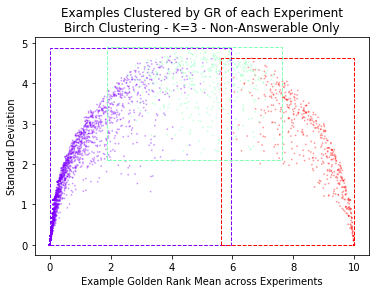

In [33]:
X = grs_na.T
X_means = grs_na_means
X_std = grs_na_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Non-Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_na_%s.png"%series) )
counts_pd.to_latex(index=False)
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    1997      0.000   0.0000  0.00000 0.000000
  Mostly Correct    2978      0.000   2.3250  0.00000 3.967918
       Uncertain     556      0.475   5.9375  0.47942 4.748273
    Mostly Wrong     384      2.525  10.0000  0.00000 4.727166
       All Wrong      13      0.000   0.0000  0.00000 0.000000


/tmp/ipykernel_1167007/808314742.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


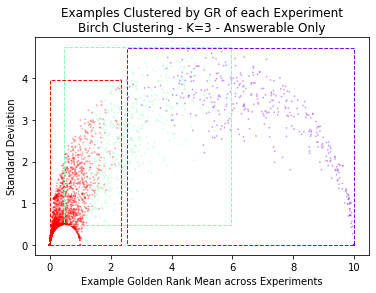

In [33]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster4_ans_%s.png"%series) )
counts_pd.to_latex(index=False)
print(counts_pd.to_string(index=False))


# Movement Analysis During Training

We start with the a numpy matrix (grls_np) that contains as many rows as validation examples (M), and as many columns as validations executed during training (N). The cells contain the GR of the example for that validation. We define the `walk` of an example to be the total magnitude of rank changes from one epock to the next. We compute it as $$W^{(i)} =  \sum_{j=0}^{N-1} \left| GR^{(i)}_{j} -  GR^{(i)}_{j+1} \right|$$ where $i$ denotes the example, and $j$ the validation index. 


(7178,)
(11873,)


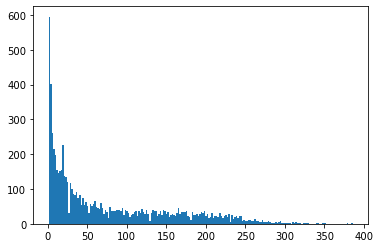

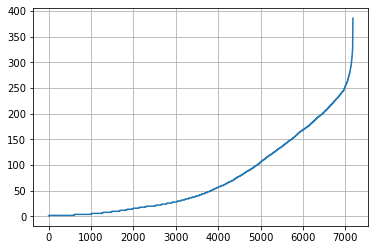

In [34]:
N,M = grls_np.shape
walk = np.sum(np.abs(grls_np[0:N-1,:]-grls_np[1:N,:]),axis = 0)
walk.sort()
wlk_nz = walk[walk>0]
print(wlk_nz.shape)
print(walk.shape)
plt.hist(wlk_nz,bins = 200)
plt.show()
save_path = Path("../assets/").joinpath("cumWalkBertLarge-train-vals%s.png"%series) 
plt.plot(wlk_nz)
plt.grid()
plt.savefig(save_path,dpi=300)
plt.show()

We also define the `movement` as the algebraic sum of the movement from the first to the last rank. We compute it as $$W^{(i)} =  GR^{(i)}_{0} -  GR^{(i)}_{N} $$ so that the positive direction is from higher ranks to lower. 

Finally we define distance as the difference between the highest and lowest GRs among all epochs of an example.  


(11873,)
D
0     4695
1     1473
2      625
3      362
4      274
5      230
6      223
7      216
8      213
9      302
10    3260
dtype: int64
Int64Index([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8,
            9, 10],
           dtype='int64', name='M')


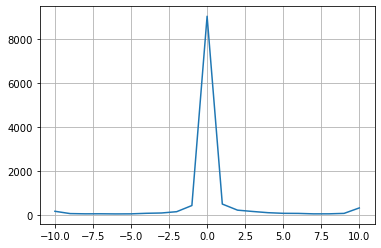

M
-10    170
-9      65
-8      54
-7      56
-6      50
-5      53
-4      78
-3      92
-2     151
-1     431
 1     498
 2     221
 3     161
 4     106
 5      77
 6      73
 7      53
 8      54
 9      74
 10    322
dtype: int64


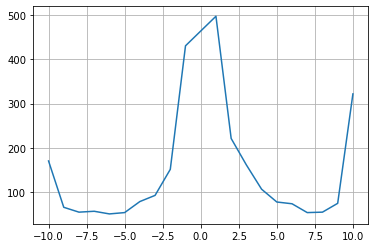

In [58]:
left=np.min(grls_np,axis=0)
right= np.max(grls_np,axis=0)
movement = grls_np[0,:] - grls_np[-1,:]
print(right.shape)
df = pd.DataFrame(np.column_stack((left,right,right-left,movement,walk)),columns=["L","R","D","M","W"])

#df.dtype=[("L",np.int32),("R",np.int32),("D",np.int32)]
df=df.sort_values(by=["D"])
print(df.groupby("D").size())
mov = df.groupby("M").size()
print(mov.index)

save_path = Path("../assets/").joinpath("MovementBertLarge-all-train-vals%s.png"%series) 
plt.plot(mov)
plt.grid()
plt.savefig(save_path,dpi=300)
plt.show()
mov_nz = mov.loc[mov.index != 0]
print(mov_nz)
save_path = Path("../assets/").joinpath("MovementBertLarge-nonzero-train-vals%s.png"%series) 
plt.plot(mov_nz)
plt.grid()
plt.savefig(save_path,dpi=300)
plt.show()

### Golden Rank (GR)



The Golden Rank $R$ is the lowest rank in the order of descenting probability of the prediction exactly matching one of the golden answers. 

The output layer of the model yields a vector of start logits and end logits for each example.  These are then passed through masked softmax producing two probability vectors, one for the start marker and another for the end marker. 

The two probability vectors for each example are then combined to form a single probability which is the value provided in the top-N results. The choice of the function that combines the two probabilities to produce the combined probability in the Huggingface implementation is a simple average of the start and end probability. There are other possibilities however:

*   The product of the two probabilities can be used instead of the average (used in the BiDAF starter code) 
*   Taking a weighted average is discussed in various articles, for example in [*Question and Answering on SQuAD 2.0: BERT Is All You Need* by Schwager and Solitario](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf). They argue that the start probability carries more weight than the end probability so weighing the start twice as much as the end may be appropriate.
*  Hyperparameter settings favoring no-answer detection have weaker scores in F1 and exact match detection, and vice versa. This observation was made by the same paper above, and we confirmed it through our own experimentation. 

We now calculate the Golden Rank from the predictions in RS. 

The value maxBins is used to size the histograms to the ranks available in the data.
The topNPreds returns a list of dictionaries, one for each experiment. 
Each of these, are indexed by example ID, and they contain the list of ranked predictions for it. 
We walk down that list and rank the id with the rank of the first correct answer we encounter. If the list goes past the maxBins, the last bin contains the rank that captures the result. If no entry exists with a correct answer, then the default rank will be used.

In [35]:
grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls = RS.calc_golden_ranks(maxBins = 10)
len(grls[5])

11873

### Mean rank

Smaller is better

In [36]:
np.mean(grls_np,axis=1)



array([1.34860608, 1.04522867, 1.19902299, 1.25410595, 1.35424914,
       1.16524888, 1.29461804, 1.06594795, 1.18579971, 1.17678767,
       0.98509223, 1.24425166, 1.15177293, 1.40377327, 1.25233724,
       1.09618462, 1.00185294, 1.25444285, 1.31660069, 1.02880485,
       1.2116567 , 1.11951487, 1.06224206, 1.10536511, 1.07277015,
       1.39130801, 1.33841489, 1.31575844, 1.2487998 , 1.22867009,
       1.17392403, 1.2116567 , 1.29604986, 1.10073275, 1.30977849,
       1.20803504, 1.21249895, 1.0937421 , 1.13139055, 1.22656447,
       1.15429967, 1.33176114, 1.09155226, 1.02324602, 1.28846964,
       1.14604565, 1.20980376, 1.22782784, 1.29967152, 1.0947528 ,
       1.41741767, 1.3002611 , 1.10999747, 1.10106965, 1.31668492,
       1.30287206, 1.11698812, 1.14949886, 1.28021562, 1.13543334,
       1.21350964, 1.31550577, 1.22024762, 1.12414722, 1.17325023,
       1.19514866, 1.10511244, 1.19220079, 1.10923945, 1.26758191,
       1.12583172, 1.17333446, 1.1745136 , 1.14073949, 1.19877

### Median Rank

In [37]:
[np.median([r  for r in L if r>0]) for L in grls]

[5.0,
 3.0,
 4.0,
 4.0,
 5.0,
 3.0,
 4.0,
 3.0,
 4.0,
 3.0,
 3.0,
 4.0,
 3.0,
 5.0,
 4.0,
 3.0,
 3.0,
 5.0,
 5.0,
 3.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 4.5,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 3.0,
 4.0,
 5.0,
 5.0,
 6.0,
 4.0,
 3.0,
 5.0,
 4.0,
 4.0,
 5.0,
 6.0,
 4.0,
 6.0,
 6.0,
 4.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 6.0,
 4.0,
 5.0,
 6.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 6.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

## Interpolated Median Rank

In [38]:
[median_grouped([r  for r in L if r>0]) for L in grls]


[5.440860215053764,
 2.7970588235294116,
 3.955223880597015,
 4.254237288135593,
 5.126126126126126,
 3.4212121212121214,
 4.353658536585366,
 2.76775956284153,
 3.726923076923077,
 3.3294797687861273,
 2.5944444444444446,
 4.378571428571428,
 3.4744318181818183,
 5.173267326732673,
 4.4393939393939394,
 3.398148148148148,
 2.638888888888889,
 4.723684210526316,
 5.169902912621359,
 2.9791666666666665,
 4.355140186915888,
 3.2066326530612246,
 3.4314285714285715,
 3.213197969543147,
 3.2885906040268456,
 5.151515151515151,
 5.010526315789473,
 5.0,
 4.354330708661418,
 5.259493670886076,
 4.173076923076923,
 4.5,
 5.10126582278481,
 3.6554621848739495,
 4.954081632653061,
 4.747524752475248,
 4.366666666666667,
 3.3862275449101795,
 3.9174311926605503,
 4.88785046728972,
 4.572164948453608,
 6.17948717948718,
 3.5384615384615383,
 3.1360544217687076,
 5.270408163265306,
 3.7880434782608696,
 4.2293233082706765,
 5.0813953488372094,
 5.645833333333333,
 3.8333333333333335,
 6.0076923076

## Scaterplots of Interpolated Median and Mean

          EMc    Median      Mean    labels        EMs        F1s    EMs_ans  \
0   23.709256  5.440860  5.688099  eval.000  76.290744  80.189013  75.067476   
1   22.563800  2.797059  4.632325  eval.001  77.436200  80.690468  73.043185   
2   23.313400  3.955224  5.143064  eval.002  76.686600  80.139982  76.518219   
3   23.683989  4.254237  5.295164  eval.003  76.316011  79.631021  74.662618   
4   24.197760  5.126126  5.596589  eval.004  75.802240  79.231414  76.197706   
..        ...       ...       ...       ...        ...        ...        ...   
75  21.443612  4.958333  5.386881  eval.075  78.556388  82.081698  77.395412   
76  21.502569  4.895000  5.379945  eval.076  78.497431  82.008775  77.277328   
77  21.536259  5.053279  5.432538  eval.077  78.463741  82.023913  77.412281   
78  21.595216  5.057252  5.452028  eval.078  78.404784  81.925997  77.665317   
79  21.275162  4.811828  5.403009  eval.079  78.724838  82.312228  75.792848   

      F1s_ans     EMs_na     F1s_na  
0

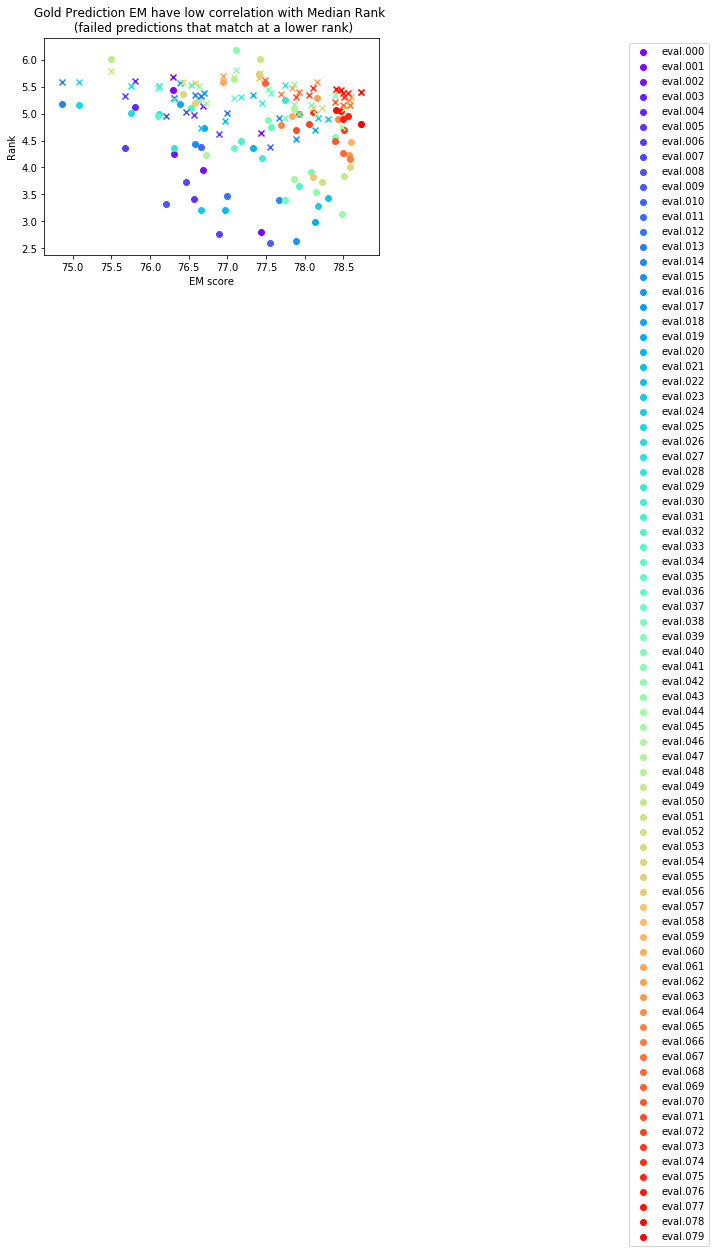

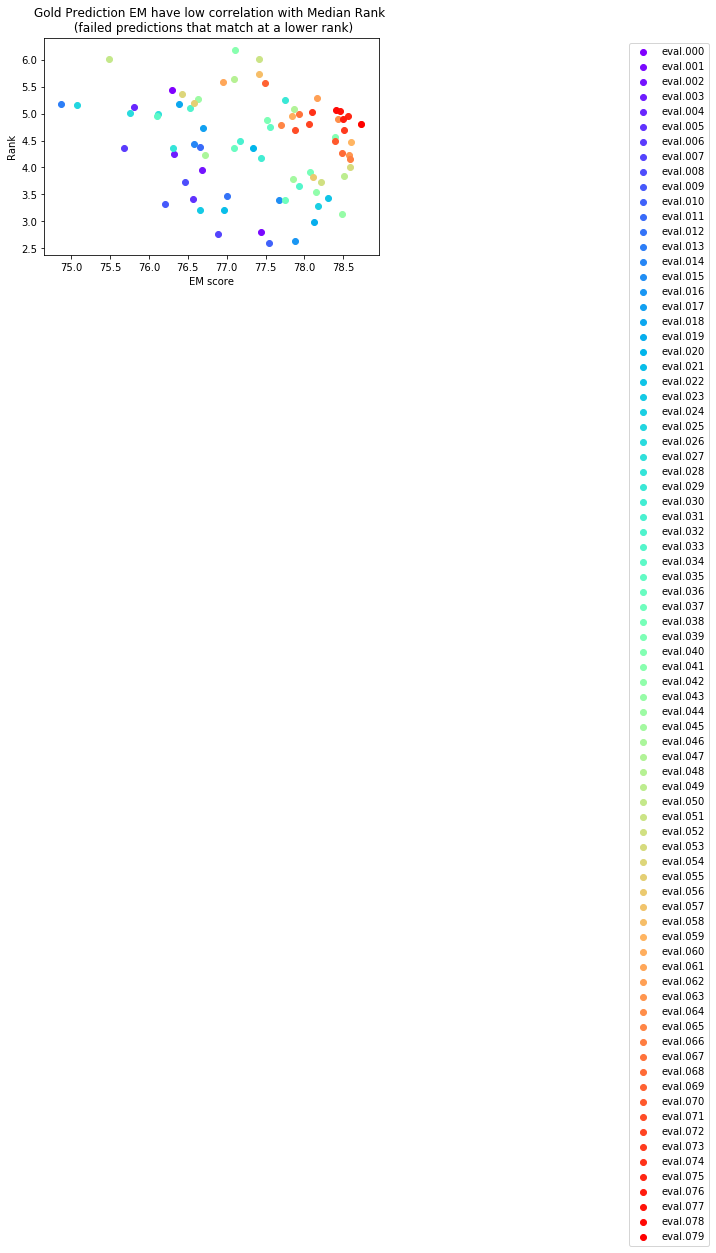

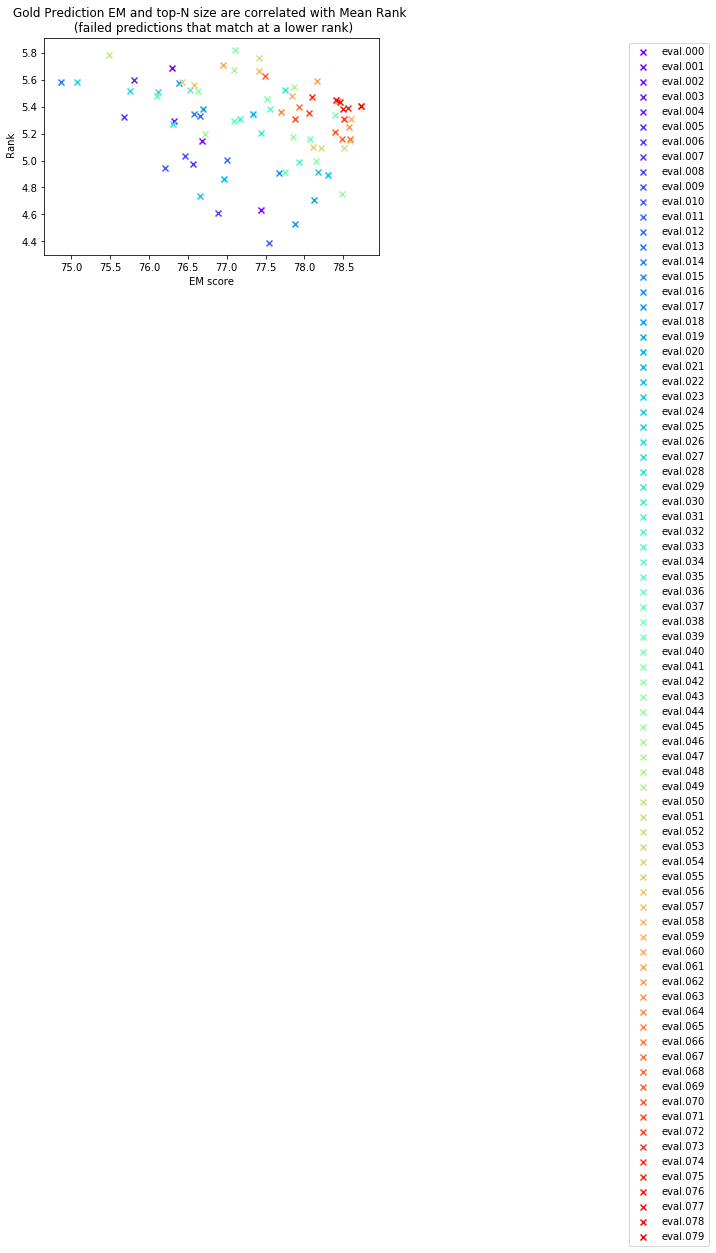

,EMc,Median,Mean,labels,EMs,F1s,EMs_ans,F1s_ans,EMs_na,F1s_na,i
0,23.709256,5.440860,5.688099,eval.000,76.290744,80.189013,75.067476,82.875193,77.510513,77.510513,0
1,22.563800,2.797059,4.632325,eval.001,77.436200,80.690468,73.043185,79.561053,81.816653,81.816653,1
2,23.313400,3.955224,5.143064,eval.002,76.686600,80.139982,76.518219,83.434887,76.854500,76.854500,2
3,23.683989,4.254237,5.295164,eval.003,76.316011,79.631021,74.662618,81.302144,77.964676,77.964676,3
4,24.197760,5.126126,5.596589,eval.004,75.802240,79.231414,76.197706,83.065887,75.407906,75.407906,4
...,...,...,...,...,...,...,...,...,...,...,...
75,21.443612,4.958333,5.386881,eval.075,78.556388,82.081698,77.395412,84.456140,79.714045,79.714045,75
76,21.502569,4.895000,5.379945,eval.076,78.497431,82.008775,77.277328,84.310084,79.714045,79.714045,76
77,21.536259,5.053279,5.432538,eval.077,78.463741,82.023913,77.412281,84.542833,79.512195,79.512195,77
78,21.595216,5.057252,5.452028,eval.078,78.404784,81.925997,77.665317,84.717842,79.142136,79.142136,78


In [39]:
grls = grls #RS.topNPreds(topK=10)
R = []
md = []
mn = []
df = []
score = []
for L in grls:
    M = len(L)
    R = [r for r in L if r > 0]
    #md.append(median_grouped(R))
    #mn.append(np.mean(R))
    #score.append(np.array(R).shape[0]/M*100)
    df.append([np.array(R).shape[0]/M*100,median_grouped(R),np.mean(R)])
#md = np.array(md)
#mn = np.array(mn)
#score = np.array(score)
df = pd.DataFrame(df)
df.columns = ['EMc','Median','Mean']
df['labels'] = RS.labels
df = pd.concat([df,metrics1],axis =1)
print(df)

#plt.scatter(score,md)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs median\n of failed predictions")
#plt.show()

#plt.scatter(score,mn)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs mean\n of failed predictions")
#plt.show()

colors = cm.rainbow(np.linspace(0, 1, len(df)))

#plt.scatter(df.EM,df.Mean,color=colors)
#plt.title("Gold Pred Rank vs median and mean\n of failed predictions")
#plt.legend(labels=df.experiment,loc='upper right', bbox_to_anchor=(2, 1))
#plt.show()

for x, y1,y2, c  in zip(100-df.EMc,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
for x, y1,y2, c  in zip(100-df.EMc,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)

plt.show()

for x, y1,y2, c  in zip(100-df.EMc,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
plt.savefig('../assets/GRvsEMtrainingEvals_%s.png'%series,dpi=300)
plt.show()

for x, y1,y2, c  in zip(100-df.EMc,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)
plt.title("Gold Prediction EM and top-N size are correlated with Mean Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel(" Rank")
plt.show()

df['i']=df.index
df

In [40]:
np.corrcoef(df.EMc,df.Median)

array([[1.        , 0.20749894],
       [0.20749894, 1.        ]])

In [41]:
np.corrcoef(df.F1s,df.Median)

array([[ 1.        , -0.15153414],
       [-0.15153414,  1.        ]])

# Training Evaluation EM-GRIM Plots

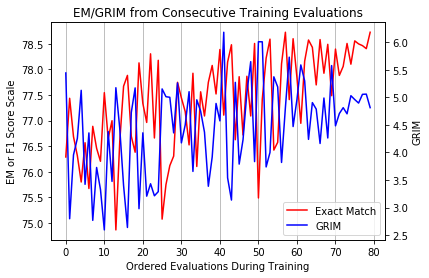

In [42]:
df['EM1'] = (100 - df['EMc'])
df['GRIMn'] = - df['Median']
dfnp = np.array(df)
ax1 = plt.subplot()
l1, = ax1.plot('EMs',data=df, color = 'red')
ax1.set_xlabel("Ordered Evaluations During Training")
ax1.set_ylabel("EM or F1 Score Scale")
ax2 = ax1.twinx()
l2, = ax2.plot('Median',data=df, color = 'blue')
ax2.set_ylabel("GRIM")
plt.title("EM/GRIM from Consecutive Training Evaluations")
plt.legend([l1, l2], ["Exact Match", "GRIM"],loc='lower right')
ax1.grid(axis = 'x')

plt.savefig("../assets/EM_GRIM_trainingEvals_%s.png"%series,dpi=300)
plt.show()

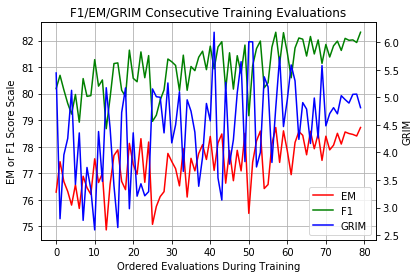

In [43]:
dfnp = np.array(df)
ax1 = plt.subplot()
l1, = ax1.plot('EMs',data=df, color = 'red')
l3, = ax1.plot('F1s',data=df, color = 'green')
ax1.set_xlabel("Ordered Evaluations During Training")
ax1.set_ylabel("EM or F1 Score Scale")
ax2 = ax1.twinx()
l2, = ax2.plot('Median',data=df, color = 'blue')
ax2.set_ylabel("GRIM")
plt.legend([l1,l3, l2], ["EM","F1", "GRIM"],loc='lower right')
plt.title("F1/EM/GRIM Consecutive Training Evaluations")
ax1.grid()
plt.savefig("../assets/F1_GRIM_trainingEvals_%s.png"%series,dpi=300)
plt.show()

In [44]:
pd.concat([df,metrics1],axis =1)

,EMc,Median,Mean,labels,EMs,F1s,EMs_ans,F1s_ans,EMs_na,F1s_na,i,EM1,GRIMn,EMs,F1s,EMs_ans,F1s_ans,EMs_na,F1s_na
0,23.709256,5.440860,5.688099,eval.000,76.290744,80.189013,75.067476,82.875193,77.510513,77.510513,0,76.290744,-5.440860,76.290744,80.189013,75.067476,82.875193,77.510513,77.510513
1,22.563800,2.797059,4.632325,eval.001,77.436200,80.690468,73.043185,79.561053,81.816653,81.816653,1,77.436200,-2.797059,77.436200,80.690468,73.043185,79.561053,81.816653,81.816653
2,23.313400,3.955224,5.143064,eval.002,76.686600,80.139982,76.518219,83.434887,76.854500,76.854500,2,76.686600,-3.955224,76.686600,80.139982,76.518219,83.434887,76.854500,76.854500
3,23.683989,4.254237,5.295164,eval.003,76.316011,79.631021,74.662618,81.302144,77.964676,77.964676,3,76.316011,-4.254237,76.316011,79.631021,74.662618,81.302144,77.964676,77.964676
4,24.197760,5.126126,5.596589,eval.004,75.802240,79.231414,76.197706,83.065887,75.407906,75.407906,4,75.802240,-5.126126,75.802240,79.231414,76.197706,83.065887,75.407906,75.407906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,21.443612,4.958333,5.386881,eval.075,78.556388,82.081698,77.395412,84.456140,79.714045,79.714045,75,78.556388,-4.958333,78.556388,82.081698,77.395412,84.456140,79.714045,79.714045
76,21.502569,4.895000,5.379945,eval.076,78.497431,82.008775,77.277328,84.310084,79.714045,79.714045,76,78.497431,-4.895000,78.497431,82.008775,77.277328,84.310084,79.714045,79.714045
77,21.536259,5.053279,5.432538,eval.077,78.463741,82.023913,77.412281,84.542833,79.512195,79.512195,77,78.463741,-5.053279,78.463741,82.023913,77.412281,84.542833,79.512195,79.512195
78,21.595216,5.057252,5.452028,eval.078,78.404784,81.925997,77.665317,84.717842,79.142136,79.142136,78,78.404784,-5.057252,78.404784,81.925997,77.665317,84.717842,79.142136,79.142136


In [45]:
N

80

(7178,)
(11873,)


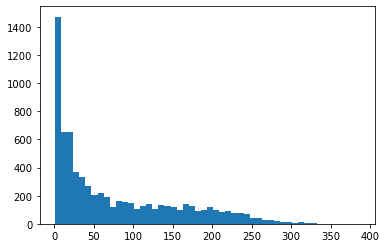

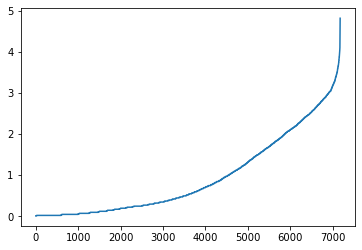

(11873,)
11873
D
0     4695
1     1473
2      625
3      362
4      274
5      230
6      223
7      216
8      213
9      302
10    3260
dtype: int64
Int64Index([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8,
            9, 10],
           dtype='int64', name='M')


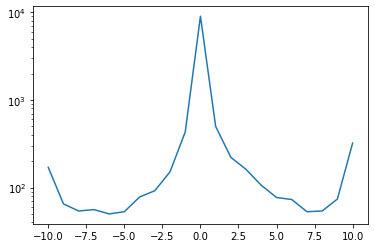

M
-10    170
-9      65
-8      54
-7      56
-6      50
-5      53
-4      78
-3      92
-2     151
-1     431
 1     498
 2     221
 3     161
 4     106
 5      77
 6      73
 7      53
 8      54
 9      74
 10    322
dtype: int64


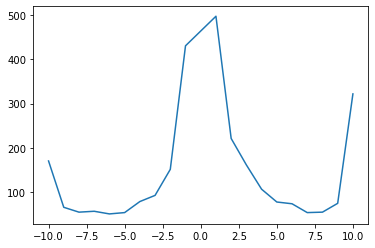

In [46]:
N,M = grls_np.shape
walk = np.sum(np.abs(grls_np[0:N-1,:]-grls_np[1:N,:]),axis = 0)
walk.sort()
wlk_nz = walk[walk>0]
print(wlk_nz.shape)
print(walk.shape)
plt.hist(wlk_nz,bins = 50)
plt.show()
plt.plot(wlk_nz/N)
plt.show()
left=np.min(grls_np,axis=0)
right= np.max(grls_np,axis=0)
movement = grls_np[0,:] - grls_np[-1,:]
print(right.shape)
df = pd.DataFrame(np.column_stack((left,right,right-left,movement,walk)),columns=["L","R","D","M","W"])
print(len(df))
#df.dtype=[("L",np.int32),("R",np.int32),("D",np.int32)]
#df=df.sort_values(by=["D"])
print(df.groupby("D").size())
mov = df.groupby("M").size()
print(mov.index)
plt.plot(mov)
plt.yscale('log')
plt.show()
mov_nz = mov.loc[mov.index != 0]
print(mov_nz)
plt.plot(mov_nz)
plt.show()
